In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
from IPython.display import display
from birdcall_distribution.data import prepare_dataframe
import pandas as pd
import matplotlib.pyplot as plt

taxonomy_df = pd.read_csv(
    "https://storage.googleapis.com/birdclef-eda-f22/data/raw/birdclef-2022/eBird_Taxonomy_v2021.csv"
)
taxonomy_df.columns = taxonomy_df.columns.str.lower()
species_mapper = taxonomy_df.set_index("species_code")["primary_com_name"].to_dict()

# NOTE: very slow
prep_df, W = prepare_dataframe(
    "../data/ee_v3_americas_5.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=None,
)
prep_df = prep_df[prep_df.index.notnull()]

In [191]:
prep_df.groupby("primary_label").count().y.sort_values(ascending=False).head(10)

primary_label
bknsti     55
sposan     51
lesyel     49
sora       45
comgal1    44
houfin     44
normoc     44
osprey     42
bcnher     39
norcar     38
Name: y, dtype: int64

In [112]:
print(prep_df.shape)
print(prep_df.primary_label.unique().size)

summed = prep_df.groupby("primary_label").y.sum().sort_values(ascending=False)
summed.head(10)

(41814, 33)
138


primary_label
norcar     500.0
normoc     387.0
wesmea     343.0
houfin     321.0
bknsti     179.0
comgal1    177.0
pibgre     159.0
saffin     151.0
lesyel     143.0
moudov     142.0
Name: y, dtype: float64

In [113]:
df = prep_df[prep_df.primary_label == "norcar"]

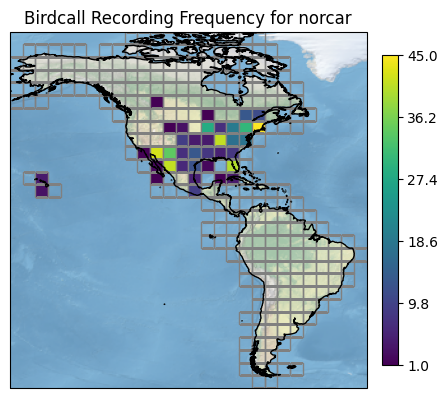

In [114]:
from birdcall_distribution.plot import plot_species

plot_species(df, "norcar")
plt.show()

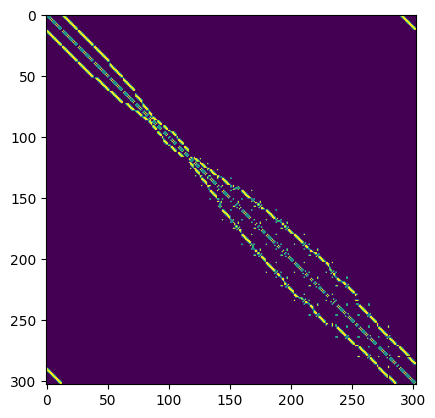

In [115]:
plt.imshow(W)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, tau_phi, phi, intercept]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 304 seconds.
Sampling: [y]


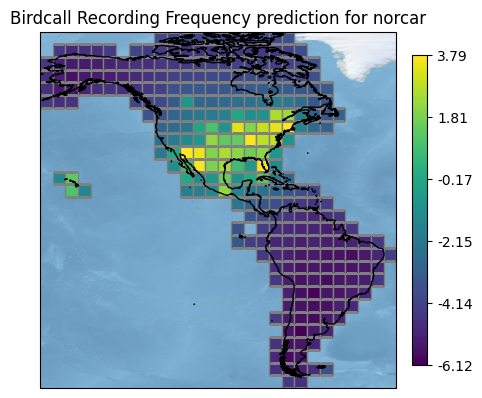

In [223]:
from birdcall_distribution import model
from birdcall_distribution.plot import plot_ppc_species
import pymc as pm
import arviz as az
import numpy as np

m1 = model.make_pooled_intercept_car_model(df, W)
with m1:
    trace1 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)
    ppc1 = pm.sample_posterior_predictive(trace1)

plot_ppc_species(df, ppc1, "norcar", prop="log_pred")
plt.show()

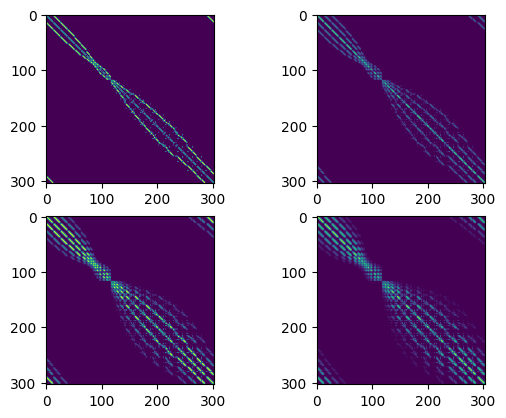

In [210]:
# make a 4x4 grid
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()
for i in range(4):
    g = W
    for j in range(i):
        g = g.dot(W)
    ax[i].imshow(g)
plt.show()

In [224]:
ppcs = []
for i in [0, 2]:
    g = W
    for j in range(i):
        g = g.dot(W)
    g = (g > 0).astype(int)
    with model.make_pooled_intercept_car_model(df, g):
        trace = pm.sample(1000, tune=1000, cores=8, target_accept=0.9)
        ppc = pm.sample_posterior_predictive(trace)
    ppcs.append(ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, tau_phi, phi, intercept]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 134 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [alpha, tau_phi, phi, intercept]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 136 seconds.
Sampling: [y]


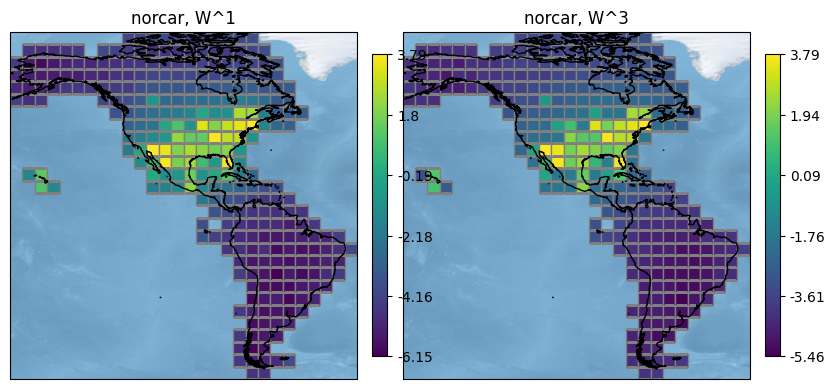

In [227]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(
    1, 2, figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree()}
)
fig.tight_layout()
for k, (i, ppc) in enumerate(zip([0, 2], ppcs)):
    plot_ppc_species(
        df, ppc, "norcar", prop="log_pred", title=f"norcar, W^{i+1}", ax=ax.flatten()[k]
    )
plt.show()

In [ ]:
m1_1 = model.make_pooled_intercept_car_model(df, W)
with m1:
    trace1 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

In [179]:
from birdcall_distribution import model

m2 = model.make_pooled_intercept_pooled_covariate_car_model(df.fillna(0), W)
with m2:
    trace2 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [alpha, tau_phi, phi, intercept, betas]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 1791 seconds.


In [180]:
az.summary(trace2, kind="stats", var_names=["~phi", "~mu"])

,mean,sd,hdi_3%,hdi_97%
intercept,-17.743,5.248,-28.540,-8.931
betas[population_density],6.230,5.102,-2.895,15.875
betas[elevation_p5],-0.751,0.601,-1.919,0.366
betas[elevation_p50],1.429,1.257,-0.952,3.829
betas[elevation_p95],-2.939,2.050,-6.897,0.823
betas[LST_Day_1km_p5],8.412,5.321,-1.498,18.680
betas[LST_Day_1km_p50],6.516,7.547,-7.366,21.295
betas[LST_Day_1km_p95],-1.402,6.434,-13.906,10.584
betas[LST_Night_1km_p5],-9.730,6.390,-21.664,2.536
betas[LST_Night_1km_p50],4.596,8.461,-11.339,20.792


Sampling: [y]


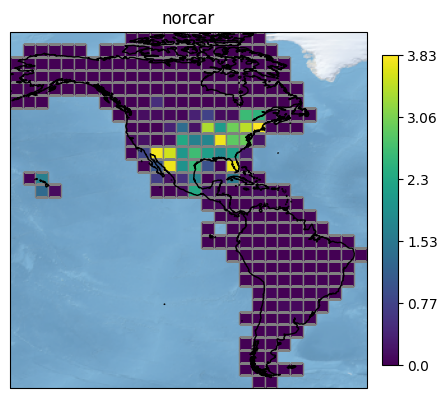

In [232]:
with m2:
    ppc2 = pm.sample_posterior_predictive(trace2)

plot_ppc_species(df, ppc2, "norcar", prop="log_pred", title="norcar")
plt.show()